# CDR for quantum dynamics
- TFIM Hamiltonian (constants not site-dependent) evolving with TDSE
- discretize the evolution steps and use first-order Trotter decomposition 

### Idea:
- get plain CDR running for Dynamics and benchmark
- check accuracy of CDR vs runtime/step division (problem is small step division, not runtime)
- add perturbation approach (all non-Cliffords) if necessary
- add noise levels (data augmentation) if necessary



In [1]:
using PauliPropagation
using Random
using Optim
using Plots
using ReverseDiff: GradientTape, gradient!, compile, gradient
using LinearAlgebra
using StatsBase 
using GLM
using DataFrames
using CSV
using Format
using Logging
using Distributions
using LaTeXStrings
include("src/cpa.jl")

run_method (generic function with 1 method)

# MWE
### Exact evolution of a small trotterized circuit (see CPDR p.7)

In [312]:
nq =9
steps = 5 
T = 0.25 
J =  2.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0  #abs(h) < abs(J) in ordered phase
angle_definition = pi/20
# paramagnetic (h = -2, J =1)
trotter = trotter_setup(nq, steps, T, J, h);
observable= obs_interaction(trotter);
min_abs_coeff = 0.0
#noisy_circuit = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01);
#noisy_circuit_layer = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01, layer = true);
noisy_circuit = realistic_gate_noise_circuit(trotter, depol_strength_single = 0.00035, dephase_strength_single = 0.00035, depol_strength_double = 0.033, dephase_strength_double = 0.033);
noisy_circuit_layer = realistic_gate_noise_circuit(trotter, depol_strength_single = 0.00035, dephase_strength_single = 0.00035, depol_strength_double = 0.033, dephase_strength_double = 0.033, layer=true);

In [313]:
print("sigma_h = ", trotter.sigma_h, " sigma_J = ",trotter.sigma_J,"    pi/20 = ", pi/20)

sigma_h = 0.1 sigma_J = -0.2    pi/20 = 0.15707963267948966

### Target data

In [314]:
exact_expval_target = trotter_time_evolution(trotter; observable = observable, record=true, min_abs_coeff=min_abs_coeff);

In [ ]:
noisy_expval_target = trotter_time_evolution(trotter; observable = observable, noise_kind="realistic", record=true, min_abs_coeff=min_abs_coeff);

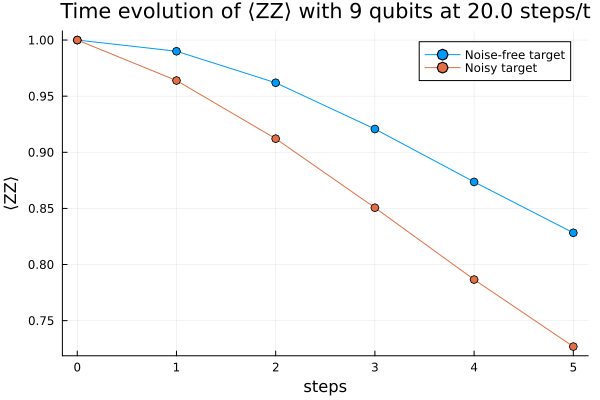

In [316]:
plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
elseif observable == obs_magnetization(trotter)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

### Training data

In [317]:
#list_training_thetas = training_set_generation_brut(trotter, angle_definition; num_samples=10, non_replaced_gates=30);

In [318]:
#list_training_thetas = training_set_generation_strict_perturbation(trotter;sample_function = "small",num_samples=10);

In [319]:
list_training_thetas = training_set_generation_loose_perturbation(trotter;sample_function = "CPA",num_samples=10);

In [320]:
exact_expvals = training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, record=true);

In [321]:
noisy_expvals = training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, noise_kind="realistic", record = true);

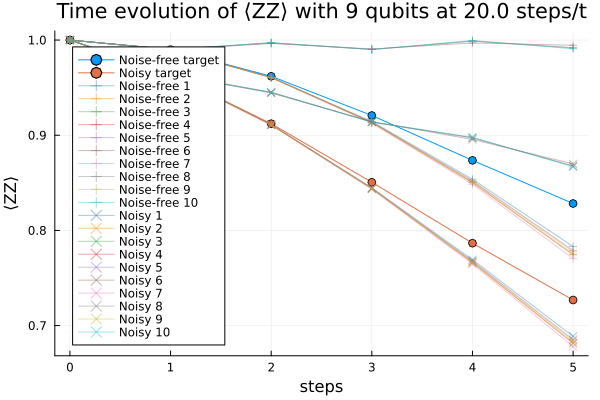

In [322]:
colors = palette(:tab10)

plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

for (i, exact) in enumerate(exact_expvals)
    plot!(0:trotter.steps, exact, label="Noise-free $(i)", c=colors[i], marker=:+, alpha = 0.4)
end

for (i, noisy) in enumerate(noisy_expvals)
    plot!(0:trotter.steps, noisy, label="Noisy $(i)", color=colors[i], marker=:x, alpha = 0.4)
end

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
else
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

In [ ]:
exact_expvals_cdr = training_trotter_time_evolution(trotter, list_training_thetas; record=true);
noisy_expvals_cdr = training_trotter_time_evolution(trotter, list_training_thetas; noise_kind="realistic", record = true);
corr_energy, rel_error_after, rel_error_before = cdr(noisy_expvals_cdr, exact_expvals_cdr, noisy_expval_target, exact_expval_target)

┌ LogLevel(100): Noisy target expectation value: 0.7268629926774581
└ @ Main /home/julia/julia_scripts/pp-em/cdr/src/cpa.jl:464
┌ LogLevel(100): Relative error before CDR: 0.12241951448821013
└ @ Main /home/julia/julia_scripts/pp-em/cdr/src/cpa.jl:465
┌ LogLevel(100): CDR-EM target expectation value: 0.8274994941811789
└ @ Main /home/julia/julia_scripts/pp-em/cdr/src/cpa.jl:466
┌ LogLevel(100): Relative error after CDR: 0.0009156950070149105
└ @ Main /home/julia/julia_scripts/pp-em/cdr/src/cpa.jl:467


(0.8274994941811789, 0.0009156950070149105, 0.12241951448821013)

In [324]:
#check ooM of error as defined in Fig 4 CPA:
MSE = (corr_energy-exact_expval_target[end])^2 #this is noise independent

5.752185634768928e-7

In [325]:
MSE_noise = (noisy_expval_target[end]-exact_expval_target[end])^2 #this is noise dependent

0.01028093246868

# Correction after every step

# CDR tests

### Full Run Test

In [22]:
#now full run is set to the loose method
global_logger(UnbufferedLogger(stdout, SubInfo))

nq = 20
steps = 8
sigma_star = pi/20
T = 0.5
J = 2.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nq, steps, T, J, h);
noise_kind = "realistic" #takes the default realistic values
min_abs_coeff = 1e-6;
min_abs_coeff_exact =1e-12;
min_abs_coeff_noisy = min_abs_coeff;
#training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples=10);
#training_set = training_set_generation_brut(trotter, sigma_star; num_samples=10, non_replaced_gates=30);
full_run(trotter, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; observable = obs_magnetization(trotter),min_abs_coeff_exact=min_abs_coeff_exact)

[SubInfo] ready to ruuuuuummmble
[SubInfo] exact_expval_target done in 0.18 s
[SubInfo] noisy_expval_target done in 0.39 s
[SubInfo] training_exact_time_evolution done in  37.53 s
[SubInfo] noisy_time_evolution done in  35.1 s
[SubInfo] Noisy target expectation value: 0.7473887841637569
[SubInfo] Relative error before CDR: 0.11642211479872823
[SubInfo] CDR-EM target expectation value: 0.8357975164394212
[SubInfo] Relative error after CDR: 0.011903553171047573
[SubInfo] cdr done in  0.0 s
[MainInfo] nq=20 noise=realistic total run done in 73.21 s


(0.845866331289525, 0.7473887841637569, 0.8357975164394212, 0.11642211479872823, 0.011903553171047573)

## CPA plots for phases of TFIM


In [ ]:
function plot_MSE_csv_data(filename::String, xaxis::String)
    data = CSV.read(filename, DataFrame)
    hasproperty(data, Symbol(xaxis)) || error("Column $xaxis not found in data")

    x = getproperty(data, Symbol(xaxis))

    plot(x, data.MSE_loose_CPA, yscale = :log10, marker = :x, label = "MSE loose CPA")
    plot!(x, data.MSE_loose_small, marker = :x, label = "MSE loose small")
    plot!(x, data.MSE_noise, marker = :x, label = "MSE noise")
    plot!(x, data.MSE_strict_CPA, marker = :x, label = "MSE strict CPA")
    plot!(x, data.MSE_strict_small, marker = :x, label = "MSE strict small")
    plot!(x, data.MSE_brut, marker = :x, label = "MSE brut",
         xlabel = xaxis == "sigma_J" ? L"\theta_J" : L"\theta_h", ylabel = "MSE", legend = xaxis == "sigma_J" ? :bottomright : :bottomleft)
end

plot_MSE_csv_data (generic function with 3 methods)

### Fig 4a) / Fig 4c)

In [43]:
#set noise
# noise_kind = "realistic"
depol_strength_double = 0.0033
dephase_strength_double = 0.0033
#leave these so we don't have to modify the code
# depol_strength = 0.00035
# dephase_strength = 0.00035
noise_kind = "gate"
depol_strength = 0.015
dephase_strength = 0.015

0.015

In [ ]:
global_logger(UnbufferedLogger(stdout,MainInfo))
#CPA system
nq = 9 #20
steps = 5 #8
sigma_star = pi/20
T = 0.5
sigma_h = 0.01:0.135:1.51 #0.135
h = sigma_h*steps/(2*T)
sigma_J = 0.01:0.135:1.51  #0 to pi/2 #to take expecation val for MSE

min_abs_coeff = 1e-10;
min_abs_coeff_exact =1e-12;
min_abs_coeff_noisy = min_abs_coeff; #also taken as truncation for noisy target circuit
num_samples = 10

MSE_loose_CPA_exp_list = []
MSE_loose_CPA_ind_list = []
MSE_loose_small_exp_list = []
MSE_loose_small_ind_list = []
MSE_noise_exp_list = []
MSE_noise_ind_list = []
MSE_strict_CPA_exp_list = []
MSE_strict_CPA_ind_list = []
MSE_strict_small_exp_list = []
MSE_strict_small_ind_list = []
MSE_brut_exp_list = []
MSE_brut_ind_list = []


function run_method(trotter, training_set,sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=10, depol_strength=0.01, dephase_strength=0.01, depol_strength_double=0.0033, dephase_strength_double=0.0033)
    exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; observable = obs_magnetization(trotter), training_set = training_set, depol_strength=depol_strength, dephase_strength=dephase_strength,depol_strength_double = depol_strength_double, dephase_strength_double = dephase_strength_double);    
    MSE_ind = (exact_expval_target - corr_energy)^2
    return MSE_ind
end

for sig_h in sigma_h 
    h = sig_h*steps/(2*T)
    for sig_J in sigma_J
        J = -sig_J*steps/(2*T)
        trotter = trotter_setup(nq, steps, T, J, h);
        training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples = num_samples);
        exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; observable = obs_magnetization(trotter), training_set = training_set, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double);
        MSE_ind = (exact_expval_target - corr_energy)^2
        push!(MSE_loose_CPA_ind_list, MSE_ind)

        MSE_noise = (exact_expval_target - noisy_expval_target)^2
        push!(MSE_noise_ind_list, MSE_noise)

        training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "small", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_loose_small_ind_list, MSE_ind)

        training_set = training_set_generation_strict_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_strict_CPA_ind_list, MSE_ind)
        
        training_set = training_set_generation_strict_perturbation(trotter, sigma_star; sample_function = "small", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_strict_small_ind_list, MSE_ind)

        training_set = training_set_generation_brut(trotter, sigma_star; num_samples = num_samples, non_replaced_gates=30);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_brut_ind_list, MSE_ind)

    end

    push!(MSE_loose_CPA_exp_list, MSE_loose_CPA_ind_list)
    push!(MSE_loose_small_exp_list, MSE_loose_small_ind_list)
    push!(MSE_strict_CPA_exp_list, MSE_strict_CPA_ind_list)
    push!(MSE_strict_small_exp_list, MSE_strict_small_ind_list)
    push!(MSE_brut_exp_list, MSE_brut_ind_list)
    push!(MSE_noise_exp_list, MSE_noise_ind_list)

    MSE_loose_CPA_ind_list = []
    MSE_loose_small_ind_list = []
    MSE_strict_CPA_ind_list = []
    MSE_strict_small_ind_list = []
    MSE_brut_ind_list = []
    MSE_noise_ind_list = []
end
MSE_loose_CPA_fig_a = []
MSE_loose_small_fig_a = []
MSE_strict_CPA_fig_a = []
MSE_strict_small_fig_a = []
MSE_brut_fig_a = []
MSE_noise_fig_a = []

for i in MSE_loose_CPA_exp_list
    MSE = mean(i)
    push!(MSE_loose_CPA_fig_a, MSE)
end
for i in MSE_loose_small_exp_list
    MSE = mean(i)
    push!(MSE_loose_small_fig_a, MSE)
end
for i in MSE_strict_CPA_exp_list
    MSE = mean(i)
    push!(MSE_strict_CPA_fig_a, MSE)
end
for i in MSE_strict_small_exp_list
    MSE = mean(i)
    push!(MSE_strict_small_fig_a, MSE)
end
for i in MSE_noise_exp_list
    MSE = mean(i)
    push!(MSE_noise_fig_a, MSE)
end
for i in MSE_brut_exp_list
    MSE = mean(i)
    push!(MSE_brut_fig_a, MSE)
end

[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.57 s
[MainInfo] nq=9 noise=gate total run done in 0.05 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.34 s
[MainInfo] nq=9 noise=gate total run done in 0.04 s
[MainInfo] nq=9 noise=gate total run done in 0.0 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.41 s
[MainInfo] nq=9 noise=gate total run done in 0.04 s
[MainInfo] nq=9 noise=gate total run done in 0.0 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.01 s
[MainInfo] nq=9 noise=gate total run done in 0.54 s
[MainInfo] nq=9 noise=gate total run done in 0.04 s
[MainInfo] nq=

In [45]:
df = DataFrame( sigma_h = sigma_h,MSE_loose_small = MSE_loose_small_fig_a, MSE_loose_CPA = MSE_loose_CPA_fig_a,  MSE_strict_small = MSE_strict_small_fig_a, MSE_strict_CPA = MSE_strict_CPA_fig_a, MSE_brut = MSE_brut_fig_a, MSE_noise = MSE_noise_fig_a)
fn = format("data/Fig_4a_noise_type={:>2s}_T={:.2f}_angdef={:.2f}_steps={:n}_nqubits={:n}_nsamples={:n}_minabs={:.2e}_minabsnoisy={:.2e}_depol={:.2e}_dephase={:.2e}.csv",  
noise_kind,T, sigma_star, steps, nq, num_samples, min_abs_coeff, min_abs_coeff_noisy,depol_strength, dephase_strength)
CSV.write(fn, df)

"data/Fig_4a_noise_type=gate_T=0.50_angdef=0.16_steps=5_nqubits=9_nsamples=10_minabs=1.00e-10_minabsnoisy=1.00e-10_depol=1.50e-02_dephase=1.50e-02.csv"

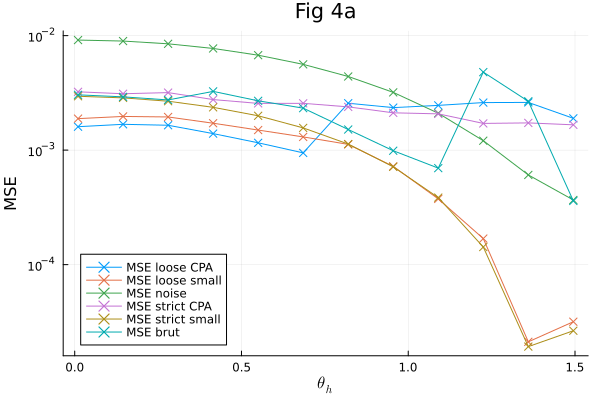

In [46]:
plot(sigma_h, MSE_loose_CPA_fig_a, yscale = :log10,  marker=:x, label="MSE loose CPA")
plot!(sigma_h, MSE_loose_small_fig_a, marker=:x, label="MSE loose small")
plot!(sigma_h, MSE_noise_fig_a, marker=:x, label="MSE noise")
plot!(sigma_h, MSE_strict_CPA_fig_a, marker=:x, label="MSE strict CPA")
plot!(sigma_h, MSE_strict_small_fig_a, marker=:x, label="MSE strict small")
plot!(sigma_h, MSE_brut_fig_a, marker=:x, label="MSE brut", xlabel=L"\theta_h", ylabel="MSE",legend=:bottomleft,title="Fig 4a")

### Fig 4b) / 4d)

In [ ]:
global_logger(UnbufferedLogger(stdout,1000))
#CPA system
nq = 20
steps = 8
sigma_star = pi/20
T = 0.5
sigma_h = 0.01:0.51:1.51 #0.135
h = sigma_h*steps/(2*T)
sigma_J = 0.01:0.135:1.51  #0 to pi/2 #to take expecation val for MSE
min_abs_coeff = 1e-10;
min_abs_coeff_noisy = min_abs_coeff;
num_samples = 10

MSE_loose_CPA_exp_list = []
MSE_loose_CPA_ind_list = []
MSE_loose_small_exp_list = []
MSE_loose_small_ind_list = []
MSE_noise_exp_list = []
MSE_noise_ind_list = []
MSE_strict_CPA_exp_list = []
MSE_strict_CPA_ind_list = []
MSE_strict_small_exp_list = []
MSE_strict_small_ind_list = []
MSE_brut_exp_list = []
MSE_brut_ind_list = []

for sig_J in sigma_J 
    J = -sig_J*steps/(2*T)
    for sig_h in sigma_h
        h = sig_h*steps/(2*T)
        
        trotter = trotter_setup(nq, steps, T, J, h);
        training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples = num_samples);
        exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; observable = obs_magnetization(trotter), training_set = training_set, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double);
        MSE_ind = (exact_expval_target - corr_energy)^2
        push!(MSE_loose_CPA_ind_list, MSE_ind)

        MSE_noise = (exact_expval_target - noisy_expval_target)^2
        push!(MSE_noise_ind_list, MSE_noise)

        training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "small", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_loose_small_ind_list, MSE_ind)

        training_set = training_set_generation_strict_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_strict_CPA_ind_list, MSE_ind)
        
        training_set = training_set_generation_strict_perturbation(trotter, sigma_star; sample_function = "small", num_samples = num_samples);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_strict_small_ind_list, MSE_ind)

        training_set = training_set_generation_brut(trotter, sigma_star; num_samples = num_samples, non_replaced_gates=30);
        MSE_ind = run_method(trotter, training_set, sigma_star, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=num_samples, depol_strength=depol_strength, dephase_strength=dephase_strength, depol_strength_double=depol_strength_double, dephase_strength_double=dephase_strength_double)
        push!(MSE_brut_ind_list, MSE_ind)

    end

    push!(MSE_loose_CPA_exp_list, MSE_loose_CPA_ind_list)
    push!(MSE_loose_small_exp_list, MSE_loose_small_ind_list)
    push!(MSE_strict_CPA_exp_list, MSE_strict_CPA_ind_list)
    push!(MSE_strict_small_exp_list, MSE_strict_small_ind_list)
    push!(MSE_brut_exp_list, MSE_brut_ind_list)
    push!(MSE_noise_exp_list, MSE_noise_ind_list)

    MSE_loose_CPA_ind_list = []
    MSE_loose_small_ind_list = []
    MSE_strict_CPA_ind_list = []
    MSE_strict_small_ind_list = []
    MSE_brut_ind_list = []
    MSE_noise_ind_list = []
end
MSE_loose_CPA_fig_b = []
MSE_loose_small_fig_b = []
MSE_strict_CPA_fig_b = []
MSE_strict_small_fig_b = []
MSE_brut_fig_b = []
MSE_noise_fig_b = []

for i in MSE_loose_CPA_exp_list
    MSE = mean(i)
    push!(MSE_loose_CPA_fig_b, MSE)
end
for i in MSE_loose_small_exp_list
    MSE = mean(i)
    push!(MSE_loose_small_fig_b, MSE)
end
for i in MSE_strict_CPA_exp_list
    MSE = mean(i)
    push!(MSE_strict_CPA_fig_b, MSE)
end
for i in MSE_strict_small_exp_list
    MSE = mean(i)
    push!(MSE_strict_small_fig_b, MSE)
end
for i in MSE_noise_exp_list
    MSE = mean(i)
    push!(MSE_noise_fig_b, MSE)
end
for i in MSE_brut_exp_list
    MSE = mean(i)
    push!(MSE_brut_fig_b, MSE)
end

In [ ]:
plot(sigma_J, MSE_loose_CPA_fig_b, yscale = :log10,  marker=:x, label="MSE loose CPA")
plot!(sigma_J, MSE_loose_small_fig_b, marker=:x, label="MSE loose small")
plot!(sigma_J, MSE_noise_fig_b, marker=:x, label="MSE noise")
plot!(sigma_J, MSE_strict_CPA_fig_b, marker=:x, label="MSE strict CPA")
plot!(sigma_J, MSE_strict_small_fig_b, marker=:x, label="MSE strict small")
plot!(sigma_J, MSE_brut_fig_b, marker=:x, label="MSE brut", xlabel=L"\theta_J", ylabel="MSE",legend=:bottomright, title = "Fig 4b")

In [ ]:
df = DataFrame( sigma_J = sigma_J,MSE_loose_small = MSE_loose_small_fig_b, MSE_loose_CPA = MSE_loose_CPA_fig_b,  MSE_strict_small = MSE_strict_small_fig_b, MSE_strict_CPA = MSE_strict_CPA_fig_b, MSE_brut = MSE_brut_fig_b, MSE_noise = MSE_noise_fig_b)
fn = format("data/Fig_4b_noise_type={:>2s}_T={:.2f}_angdef={:.2f}_steps={:n}_nqubits={:n}_nsamples={:n}_minabs={:.2e}_minabsnoisy={:.2e}_depol={:.2e}_dephase={:.2e}.csv",  
T, sigma_star, steps, nq, num_samples, min_abs_coeff, min_abs_coeff_noisy,depol_strength, dephase_strength)
CSV.write(fn, df)